<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Signals:-change-over-time" data-toc-modified-id="Signals:-change-over-time-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Signals: change over time</a></span><ul class="toc-item"><li><span><a href="#Animation:-changing-luminance/intensity-over-time" data-toc-modified-id="Animation:-changing-luminance/intensity-over-time-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Animation: changing luminance/intensity over time</a></span></li><li><span><a href="#Animation:-flicker-and-bar" data-toc-modified-id="Animation:-flicker-and-bar-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Animation: flicker and bar</a></span></li><li><span><a href="#Animation:-flicker,-bar,-and-trace" data-toc-modified-id="Animation:-flicker,-bar,-and-trace-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Animation: flicker, bar, and trace</a></span></li></ul></li><li><span><a href="#Signal-parameters" data-toc-modified-id="Signal-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Signal parameters</a></span></li><li><span><a href="#Frequency-domain-description-of-a-signal:-Fourier-transform" data-toc-modified-id="Frequency-domain-description-of-a-signal:-Fourier-transform-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Frequency-domain description of a signal: Fourier transform</a></span><ul class="toc-item"><li><span><a href="#Amplitude-and-frequency-in-the-frequency-domain" data-toc-modified-id="Amplitude-and-frequency-in-the-frequency-domain-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Amplitude and frequency in the frequency domain</a></span></li><li><span><a href="#How-signal-parameters-show-up-in-the-frequency-domain" data-toc-modified-id="How-signal-parameters-show-up-in-the-frequency-domain-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>How signal parameters show up in the frequency domain</a></span><ul class="toc-item"><li><span><a href="#0-Hz-frequency" data-toc-modified-id="0-Hz-frequency-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>0 Hz frequency</a></span></li></ul></li><li><span><a href="#Phase" data-toc-modified-id="Phase-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Phase</a></span></li><li><span><a href="#DFT-resolution" data-toc-modified-id="DFT-resolution-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>DFT resolution</a></span></li><li><span><a href="#Power-spectrum" data-toc-modified-id="Power-spectrum-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Power spectrum</a></span></li></ul></li><li><span><a href="#Compound-waveforms:" data-toc-modified-id="Compound-waveforms:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compound waveforms:</a></span><ul class="toc-item"><li><span><a href="#Multiplying-==-adding-the-same-waveform" data-toc-modified-id="Multiplying-==-adding-the-same-waveform-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Multiplying == adding the same waveform</a></span></li><li><span><a href="#Adding-different-sinusoids" data-toc-modified-id="Adding-different-sinusoids-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Adding different sinusoids</a></span></li><li><span><a href="#Squarewave" data-toc-modified-id="Squarewave-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Squarewave</a></span></li><li><span><a href="#Signal-in-&quot;noise&quot;" data-toc-modified-id="Signal-in-&quot;noise&quot;-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Signal in "noise"</a></span></li></ul></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Filtering</a></span></li><li><span><a href="#Spatial-frequency-(1D)" data-toc-modified-id="Spatial-frequency-(1D)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Spatial frequency (1D)</a></span><ul class="toc-item"><li><span><a href="#Single-sinusoid:-stack-frames-to-become-image" data-toc-modified-id="Single-sinusoid:-stack-frames-to-become-image-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Single sinusoid: stack frames to become image</a></span></li><li><span><a href="#Cycles-per-degree" data-toc-modified-id="Cycles-per-degree-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Cycles per degree</a></span></li><li><span><a href="#Another-example:-Gaussian" data-toc-modified-id="Another-example:-Gaussian-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Another example: Gaussian</a></span></li><li><span><a href="#&quot;Gabor&quot;" data-toc-modified-id="&quot;Gabor&quot;-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>"Gabor"</a></span></li></ul></li></ul></div>

In [202]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import time
import scipy.fft
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output, display, HTML
import ipywidgets as widgets
import cv2

%matplotlib inline

## Spatial frequency (1D)

### Stack frames to become image
Let's have a look at our flickering signal again.

In [60]:
duration = 4 # seconds
sampling_rate = 32 # sample per sec

times = np.linspace(start=0, stop=duration, num=sampling_rate*duration, endpoint=False)

# Produce sinusoidal luminance (L) signal
original_frequency = 1
original_amplitude = 1
original_phase = 1

In [61]:
def sinusoid(frequency, times=times, amplitude=1, phase=0, mean=0):
    return amplitude * np.cos(2*np.pi*frequency*times + phase) + mean

def animate_flicker(waveform, times, sampling_rate):
    fig, ax = plt.subplots()
    img = ax.imshow(np.zeros((3,3)), cmap="gray", vmin=-1, vmax=1, animated=True)
    plt.axis('off')
    
    def animate(frame_num):
        img_array = img.get_array()
        img_array[1,1] = waveform[frame_num-1]
        img.set_array(img_array)
        return (img, )
    
    display(HTML(FuncAnimation(fig, animate, blit=True, frames=len(waveform), interval=1000/sampling_rate).to_jshtml()))
    plt.close()

In [62]:
L = sinusoid(frequency=original_frequency, amplitude=original_amplitude, phase=original_phase)
animate_flicker(L, times, sampling_rate)

Imagine that rather than playing all the frames of our flickering light animation
one after the other
and instead took (some of) these frames and placed them next to each other:

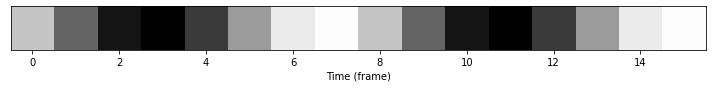

In [63]:
idc = np.arange(0, 2*sampling_rate, step=sampling_rate/8).astype(int)

fig, ax = plt.subplots(figsize=(10, 3))
ax.imshow(L[idc] * np.ones((1,len(idc))), cmap="gray", vmin=-1, vmax=1)
ax.set_aspect(1)
ax.yaxis.set_visible(False)
ax.set_xlabel("Time (frame)")
fig.tight_layout()
plt.show()

Since the pattern across frames is the same
as when we played it as animation,
we can still describe these frames as a sinusoidal signal --
see how the (relative) intensity in each frame is still indicated
by the height of the waveform:

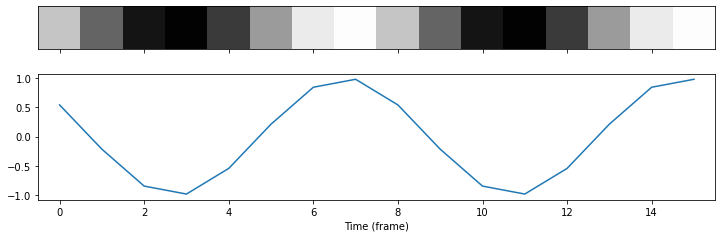

In [64]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex="all", figsize=(10, 4))
ax1.imshow(L[idc] * np.ones((1,len(idc))), cmap="gray", vmin=-1, vmax=1)
ax1.set_aspect(1)
ax1.yaxis.set_visible(False)

ax2.plot(L[idc])
ax2.set_xlabel("Time (frame)")
fig.tight_layout()
plt.show()

Now let's take all our frames and put them side-by-side this way.
It will be a lot frames, and the intensity change from one to another is small
so you won't be able to really see the border between one frame and its neighbor anymore.

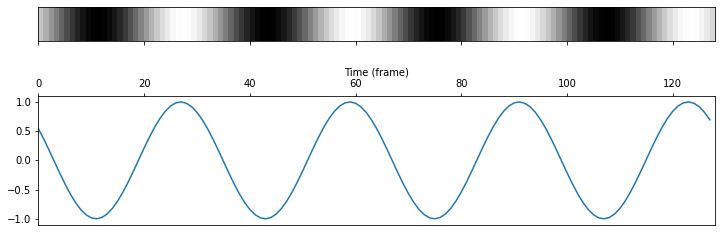

In [65]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex="all", figsize=(10, 4))
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1, extent=(0, len(times), 0, len(times)/20))
ax1.yaxis.set_visible(False)
ax1.xaxis.tick_bottom()

ax2.plot(L)
ax2.set_xlabel("Time (frame)")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
fig.tight_layout()
plt.show()

The signal is still perfectly described by the waveform
-- but now it instead of flickering light, it looks like a grating!
Instead of changing contrast over _time_ (flickering),
is represented such that contrast changes over _space_.

How should we think about this?

Let's remind ourselves of some aspects of our signal:

In [66]:
print(f"Frequency is {original_frequency} cycle(s) per second")
print(f"Duration is {duration} second(s), sampled with {sampling_rate*duration} frames (= at {sampling_rate} fps)")
print(f"{original_frequency * duration} cycle(s) total, in {sampling_rate*duration} frames total")

Frequency is 1 cycle(s) per second
Duration is 4 second(s), sampled with 128 frames (= at 32 fps)
4 cycle(s) total, in 128 frames total


Well, _we_ decided each sample represents a temporal frame.
We can also decided that each sample represents a pixel:

In [67]:
print(f"{sampling_rate*duration} frames becomes {sampling_rate*duration} pixels")
print(f"{original_frequency * duration} cycle(s) total stays {original_frequency * duration} cycle(s) total")

128 frames becomes 128 pixels
4 cycle(s) total stays 4 cycle(s) total


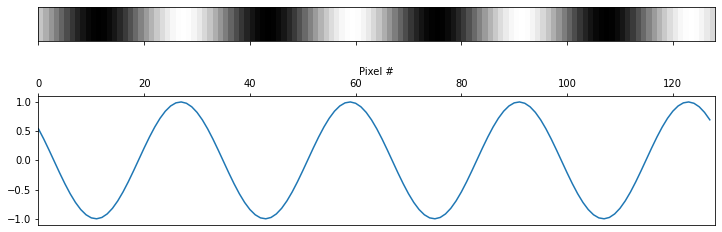

In [68]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex="all", figsize=(10, 4))
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1, extent=(0, len(times), 0, len(times)/20))
ax1.yaxis.set_visible(False)

ax2.plot(L)
ax2.set_xlabel("Pixel #")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
fig.tight_layout()
plt.show()

### Spatial frequency: cycles per image; cycles per degree

The least simple of this, is how to express the now _spatial_ frequency.
We can of course just express the total number of _cycles per image_:

In [69]:
print(f"{original_frequency * duration} cycle(s) per image")

4 cycle(s) per image


but that would be akin to expressing the temporal frequency as "cycles per X total seconds".
Instead, we should use a physical unit for space. We could use cm, inches, etc.

In vision science, the logical choice is _degrees of visual angle_.
As a result, our unit of frequency becomes _cycles per degree of visual angle_, or _cpd_ for short.

Similarly, the sampling rate is now not _frames per second_,
but _pixels per degree of visual angle_, or _ppd_ for short.

In [70]:
print(f"Frequency is {original_frequency} cycle(s) per degree")
print(f"Visual extent is {duration} degree(s), sampled with {sampling_rate*duration} pixels (= at {sampling_rate} ppd)")
print(f"{original_frequency * duration} cycle(s) total, in {sampling_rate*duration} pixels (= pixels per image)")

Frequency is 1 cycle(s) per degree
Visual extent is 4 degree(s), sampled with 128 pixels (= at 32 ppd)
4 cycle(s) total, in 128 pixels (= pixels per image)


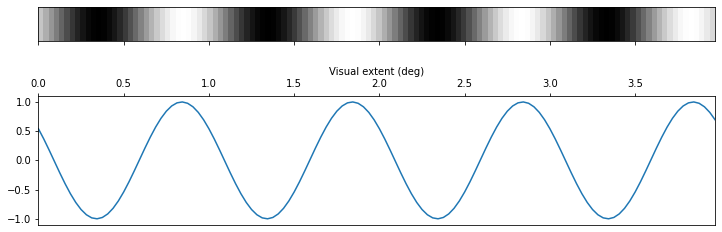

In [71]:
x = times
ppd = sampling_rate

fig, (ax1, ax2) = plt.subplots(2,1, sharex="all", figsize=(10, 4))
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1, extent=(x.min(), x.max(), 0, x.max()/20))
ax1.yaxis.set_visible(False)

ax2.plot(x, L)
ax2.set_xlabel("Visual extent (deg)")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
fig.tight_layout()
plt.show()

...or if we center the image on $(0,0)$ degrees...

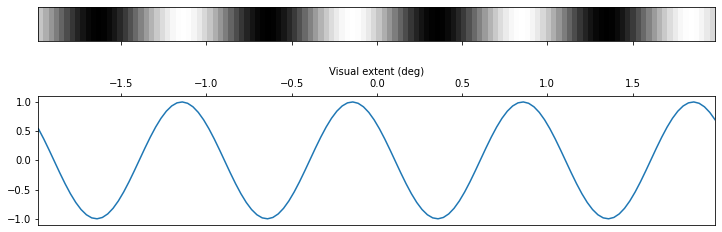

In [72]:
x = times - np.max(times)/2

fig, (ax1, ax2) = plt.subplots(2,1, sharex="all", figsize=(10, 4))
ax1.imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1, extent=(x.min(), x.max(), 0, x.max()/10))
ax1.yaxis.set_visible(False)

ax2.plot(x, L)
ax2.set_xlabel("Visual extent (deg)")
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
fig.tight_layout()
plt.show()

The nice thing is that the Fourier transform does not care about any of these units,
or even whether your signal is in time or space!

We can take the exact same Fourier transform of our signal and plot the spectrum;
the only thing we need to change is the axis labels.

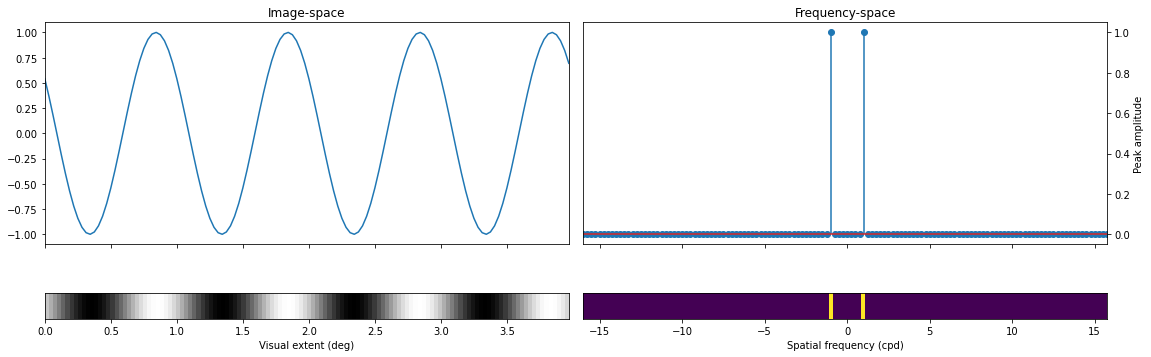

In [73]:
x = times
FL = scipy.fft.fft(L)
freqs = scipy.fft.fftfreq(len(L), d=(1/sampling_rate))
amplitude_spectrum = np.abs(FL)
peak_amplitudes = amplitude_spectrum / (2*sampling_rate)

fig, axes = plt.subplots(2, 2, sharex="col", figsize=(16, 6))
axes[0,0].plot(x, L)

axes[0,1].stem(freqs, peak_amplitudes)
axes[0,1].yaxis.tick_right(), axes[0,1].yaxis.set_label_position("right")
axes[0,1].set_ylabel("Peak amplitude"), axes[0,0].set_title("Image-space")

axes[1,0].imshow(L * np.ones((1,len(L))), cmap="gray", vmin=-1, vmax=1, extent=(np.min(x), np.max(x), 0, np.max(x)/20))
axes[1,0].yaxis.set_visible(False)
axes[1,0].set_xlabel("Visual extent (deg)")

axes[1,1].imshow(scipy.fft.fftshift(peak_amplitudes) * np.ones((1,len(peak_amplitudes))), extent=(freqs.min(), freqs.max(), 0, np.max(freqs)/10))
axes[1,1].yaxis.set_visible(False)
axes[1,1].set_xlabel("Spatial frequency (cpd)"), axes[0,1].set_title("Frequency-space")

fig.tight_layout()
plt.show()

**Spatial frequency (as compared to temporal frequency) is not else than a relabeling of axes and units!**

## From 1d to 2d space

### Repeating 1d sine-wave
Let's start with sine-waves again and simply repeat our previous signal by repeating its rows.

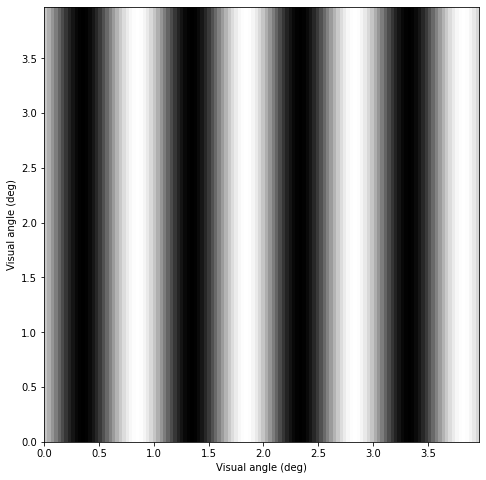

In [74]:
L_2d = np.repeat(np.expand_dims(L, 0), len(L), axis=0)

plt.figure(figsize=(8, 8))
plt.imshow(L_2d, cmap='gray', extent=(x.min(), x.max(),)*2)
plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)')
plt.show()

### FFT in two dimensions

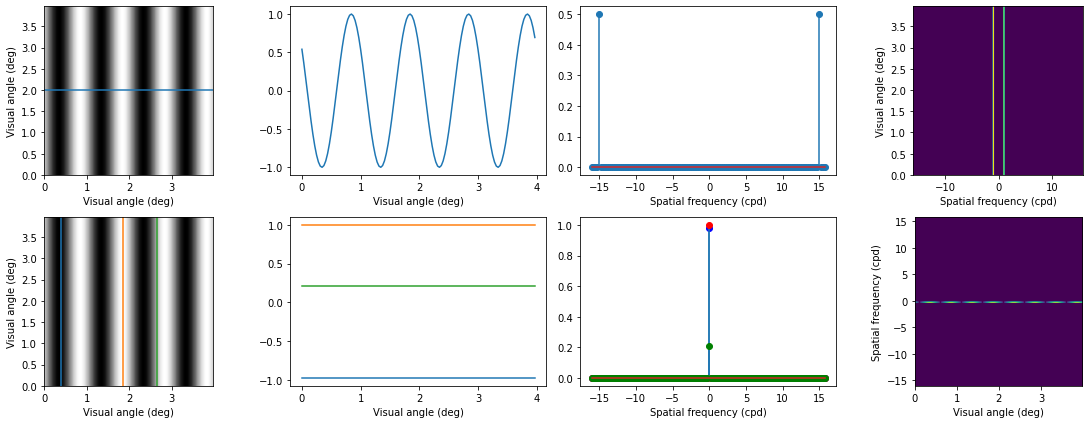

In [79]:
f = scipy.fft.fftshift(scipy.fft.fftfreq(len(L), d=(1/ppd)))

# Compute fft in x-direction
FL_x = scipy.fft.fft2(L_2d, axes=1)
amplitude_x = np.abs(np.fft.fftshift(FL_x)) / np.size(L)

# Compute fft in y-direction
FL_y = scipy.fft.fft2(L_2d, axes=0)
amplitude_y = np.abs(np.fft.fftshift(FL_y)) / np.size(L)

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes[0,0].imshow(L_2d, cmap='gray', extent=(x.min(), x.max(),)*2)
axes[0,0].plot((x.min(), x.max()), (2., 2.))
axes[0,0].set_xlabel('Visual angle (deg)'), axes[0,0].set_ylabel('Visual angle (deg)')
axes[0,1].plot(x, L), axes[0,1].set_xlabel('Visual angle (deg)')
axes[0,2].stem(freqs, amplitude_x[10, :]), axes[0,2].set_xlabel('Spatial frequency (cpd)')
axes[0,3].imshow(amplitude_x, extent=(f.min(), f.max(), x.min(), x.max()))
axes[0,3].set_aspect(f.max() / x.max()*2)
axes[0,3].set_xlabel('Spatial frequency (cpd)'), axes[0,3].set_ylabel('Visual angle (deg)')

axes[1,0].imshow(L_2d, cmap='gray', extent=(x.min(), x.max(),)*2)
axes[1,0].set_xlabel('Visual angle (deg)'), axes[1,0].set_ylabel('Visual angle (deg)')
axes[1,0].plot((0.4, 0.4), (x.min(), x.max()))
axes[1,0].plot((1.85, 1.85), (x.min(), x.max()))
axes[1,0].plot((2.65, 2.65), (x.min(), x.max()))
axes[1,1].plot(x, L_2d[:, int(0.4*ppd)])
axes[1,1].plot(x, L_2d[:, int(1.85*ppd)])
axes[1,1].plot(x, L_2d[:, int(2.65*ppd)]), axes[1,1].set_xlabel('Visual angle (deg)')
axes[1,2].stem(f, amplitude_y[:, int(0.4*ppd)], markerfmt='bo')
axes[1,2].stem(f, amplitude_y[:, int(1.85*ppd)], markerfmt='ro')
axes[1,2].stem(f, amplitude_y[:, int(2.65*ppd)], markerfmt='go'), axes[1,2].set_xlabel('Spatial frequency (cpd)')
axes[1,3].imshow(amplitude_y, extent=(x.min(), x.max(), f.min(), f.max()))
axes[1,3].set_aspect(x.max()/2 / f.max())
axes[1,3].set_xlabel('Visual angle (deg)'), axes[1,3].set_ylabel('Spatial frequency (cpd)')

fig.tight_layout()
plt.show()

Now, we have an idea how the fft looks individually in the x- and the y-direction.
In order to perform the full 2d-fft, we can simply perform a 1d-fft along the missing direction.
Nice that fft is decomposable.

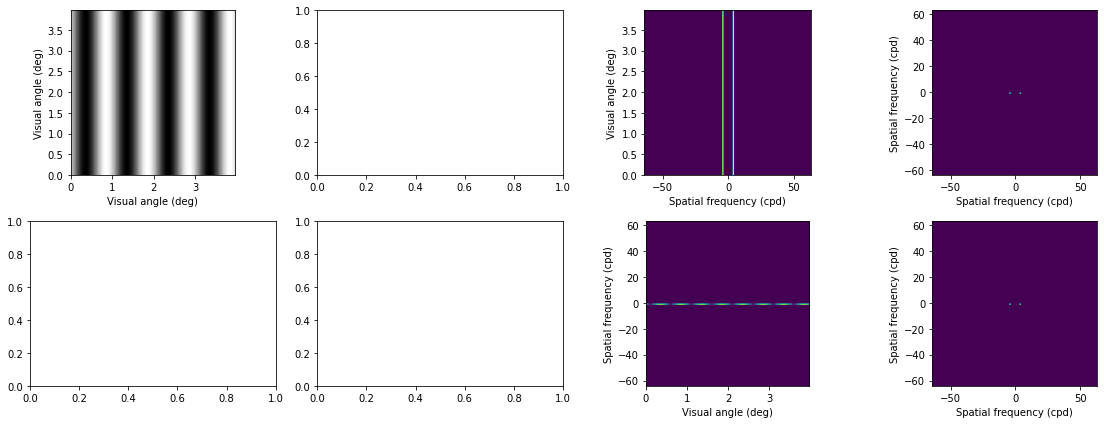

In [52]:
# Compute fft in x-direction and then y-direction
amplitude_xy = np.abs(scipy.fft.fftshift(scipy.fft.fft2(scipy.fft.fft2(L_2d, axes=1), axes=0))) / np.size(L_2d)

# Compute fft in y-direction and then x-direction
amplitude_yx = np.abs(scipy.fft.fftshift(scipy.fft.fft2(scipy.fft.fft2(L_2d, axes=0), axes=1))) / np.size(L_2d)

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes[0,0].imshow(L_2d, cmap='gray', extent=(x.min(), x.max(),)*2)
axes[0,0].set_xlabel('Visual angle (deg)'), axes[0,0].set_ylabel('Visual angle (deg)')

axes[0,2].imshow(amplitude_x, extent=(f.min(), f.max(), x.min(), x.max()))
axes[0,2].set_aspect(f.max() / x.max()*2)
axes[0,2].set_xlabel('Spatial frequency (cpd)'), axes[0,2].set_ylabel('Visual angle (deg)')
axes[1,2].imshow(amplitude_y, extent=(x.min(), x.max(), f.min(), f.max()))
axes[1,2].set_aspect(x.max()/2 / f.max())
axes[1,2].set_xlabel('Visual angle (deg)'), axes[1,2].set_ylabel('Spatial frequency (cpd)')

axes[0,3].imshow(amplitude_xy, extent=(f.min(), f.max(),)*2)
axes[0,3].set_xlabel('Spatial frequency (cpd)'), axes[0,3].set_ylabel('Spatial frequency (cpd)')
axes[1,3].imshow(amplitude_yx, extent=(f.min(), f.max(),)*2)
axes[1,3].set_xlabel('Spatial frequency (cpd)'), axes[1,3].set_ylabel('Spatial frequency (cpd)')

fig.tight_layout()
plt.show()

Instead of manually performing the fft in both directions, there is a convenvience function called fft2 which produces the same output.

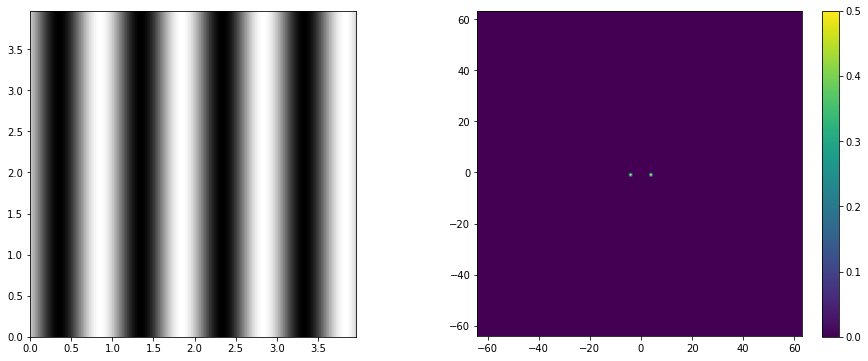

In [50]:
FL_2d = np.fft.fftshift(scipy.fft.fft2(L_2d))
amplitude_2d = np.abs(FL_2d) / np.size(L_2d)

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.imshow(L_2d, cmap='gray', extent=(x.min(), x.max(),)*2)

plt.subplot(122)
plt.imshow(amplitude_2d, extent=(f.min(), f.max(),)*2)
plt.colorbar()
plt.show()

### 2d sine-wave gratings: orientation
When creating a 2d sine-wave grating, there are some additional parameters that we can vary.
Next to the parameters frequency, phase, amplitude and mean, we can also change the orientation of the sine-wave in 2d space.

In [94]:
ppd = 128.
extent = [1., 1.]
nY, nX = int(ppd*extent[0]), int(ppd*extent[1])
f = scipy.fft.fftshift(scipy.fft.fftfreq(nX, d=(1/ppd)))

def grating(frequency, orientation=0., phase=0, amplitude=1., mean=0., ppd=ppd, extent=extent):
    y = np.arange(0, extent[0], 1./ppd)
    x = np.arange(0, extent[1], 1./ppd)
    yy, xx = np.meshgrid(y, x)
    alpha = [np.cos(orientation), np.sin(orientation)]
    return amplitude * np.sin((alpha[0]*xx + alpha[1]*yy) * 2. * np.pi * frequency + phase) + mean

In [95]:
def plot_gratings(frequency, orientation, phase, amplitude, mean):
    # Generate sinusoid
    g = grating(frequency, orientation*np.pi/180., phase*np.pi/180, amplitude, mean)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.imshow(g, cmap='gray', extent=[0,extent[0],0,extent[1]])
    plt.colorbar()
    plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)')
    
    
interactive_plot = widgets.interactive(plot_gratings, frequency=(0, sampling_rate/2, 4/sampling_rate), orientation=(0,90), phase=(0,90), amplitude=(0, 2, 0.1), mean=(-1,1,0.1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=8.0, description='frequency', max=16.0, step=0.125), IntSlider(value=4…

In [171]:
def helper_plot(g):
    extent = (g.shape[0] / ppd, g.shape[1] / ppd)
    f = scipy.fft.fftshift(scipy.fft.fftfreq(g.shape[0], d=(1/ppd)))

    # Perform fft
    g_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(g))) / np.size(g)

    # Plot
    plt.figure(figsize=(16, 3))
    plt.subplot(141)
    plt.imshow(g, cmap='gray', extent=[0,extent[0],0,extent[1]])
    plt.colorbar()
    plt.plot([0, extent[0]], [extent[1]/2., extent[1]/2.], 'r')
    plt.plot([extent[0]/2., extent[0]/2.], [0, extent[1]], 'b')
    plt.xlabel('Visual angle (deg)'), plt.ylabel('Visual angle (deg)'), plt.title('2d grating')
    
    plt.subplot(142)
    plt.plot(np.linspace(0, extent[0], int(ppd*extent[0]),), g[int(g.shape[0]/2), :], 'r')
    plt.plot(np.linspace(0, extent[1], int(ppd*extent[1]),), g[:, int(g.shape[1]/2)], 'b')
    plt.xlabel('Visual angle (deg)'), plt.title('Cut-throughs')
    
    plt.subplot(143)
    plt.imshow(g_amp, extent=[f.min(), f.max(),]*2)
    plt.plot([f.min(), f.max()], [0, 0], 'w--', linewidth=0.3)
    plt.plot([0, 0], [f.min(), f.max()], 'w--', linewidth=0.3)
    plt.colorbar(), plt.title('Amplitude spectrum')
    
    plt.subplot(144)
    plt.imshow(np.log(g_amp+0.001), extent=[f.min(), f.max(),]*2)
    plt.plot([f.min(), f.max()], [0, 0], 'w--', linewidth=0.3)
    plt.plot([0, 0], [f.min(), f.max()], 'w--', linewidth=0.3)
    plt.colorbar(), plt.title('Amplitude spectrum (log)')


def plot_gratings(frequency, orientation, phase, amplitude, mean):
    # Generate sinusoid
    g = grating(frequency, orientation*np.pi/180., phase*np.pi/180, amplitude, mean)
    helper_plot(g)
    
    
interactive_plot = widgets.interactive(plot_gratings, frequency=(0, sampling_rate/2, 4/sampling_rate), orientation=(0,90), phase=(0,90), amplitude=(0, 2, 0.1), mean=(-1,1,0.1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=8.0, description='frequency', max=16.0, step=0.125), IntSlider(value=4…

## Going beyond sine-waves: Relevant signals

### Compound signals

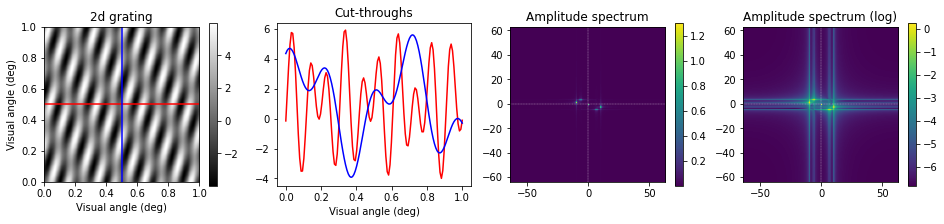

In [172]:
compound = grating(7.7, 1., 0, 2, 1) + grating(10.3, 1.4, 0, 3., 0)
helper_plot(compound)

### (Oriented) Gaussians

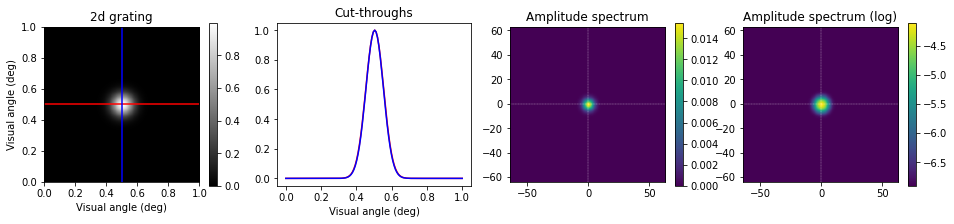

In [173]:
def gaussian2d(x, y, sigma, orientation=0):
    # determine a, b, c coefficients
    a = (np.cos(orientation)**2 / (2*sigma[0]**2)) + (np.sin(orientation)**2 / (2*sigma[1]**2))
    b = -(np.sin(2*orientation) / (4*sigma[0]**2)) + (np.sin(2*orientation) / (4*sigma[1]**2))
    c = (np.sin(orientation)**2 / (2*sigma[0]**2)) + (np.cos(orientation)**2 / (2*sigma[1]**2))

    # create Gaussian
    gaussian = np.exp(-(a*x**2 + 2*b*x*y + c*y**2))
    return gaussian


y, x = np.linspace(-extent[0]/2, extent[0]/2 - 1/ppd, nY), np.linspace(-extent[1]/2 - 1/ppd, extent[1]/2, nX)
yy, xx = np.meshgrid(y, x)
gauss = gaussian2d(xx, yy, [0.05, 0.05], 0.)
helper_plot(gauss)

### Gabors / Windowed sine-wave gratings
Good localization in image-space and good attributes in frequency domain.

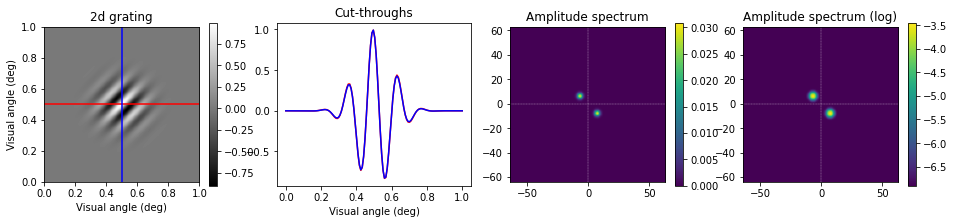

In [174]:
gabor = grating(10., np.pi/4, np.pi/2) * gaussian2d(xx, yy, [0.1, 0.1], 0.)
helper_plot(gabor)

### Natural images

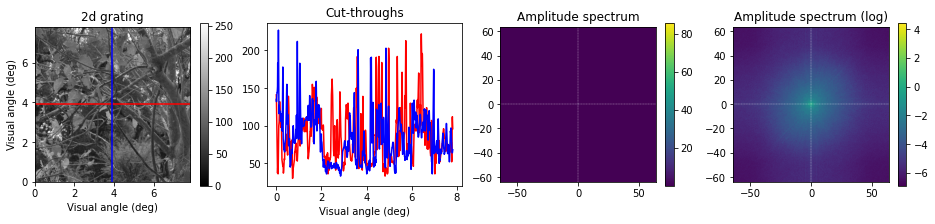

In [188]:
# Import natural image and crop
img = cv2.imread('upenn_natural_image_database_DSC_0004.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img[0:1000, 0:1000]
helper_plot(img)

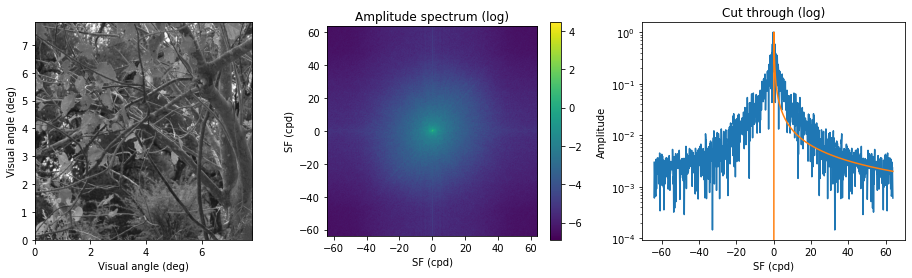

In [207]:
f_img = scipy.fft.fftshift(scipy.fft.fftfreq(1000, d=(1/ppd)))

# Perform fft
img_amp = np.abs(scipy.fft.fftshift(scipy.fft.fft2(img))) / np.size(img)

plt.figure(figsize=(16, 4))
plt.subplot(131, aspect=1.)
plt.imshow(img, cmap='gray', extent=[0., 1000/ppd,]*2)
plt.ylabel('Visual angle (deg)'), plt.xlabel('Visual angle (deg)')

plt.subplot(132)
plt.imshow(np.log(img_amp+0.001), extent=[f_img.min(), f_img.max(),]*2)
plt.ylabel('SF (cpd)'), plt.xlabel('SF (cpd)'), plt.title('Amplitude spectrum (log)'), plt.colorbar()

amp1d = img_amp[int(1000/2.), :]
amp_1f = 1/f_img[f_img!=0]
plt.subplot(133)
plt.plot(f_img[f_img!=0], amp1d[f_img!=0] / amp1d[f_img!=0].max())
plt.plot(f_img[f_img!=0], amp_1f / amp_1f.max())
plt.title('Cut through (log)')
plt.ylabel('Amplitude'), plt.xlabel('SF (cpd)'), plt.yscale('log')
plt.show()

### Square-wave grating
Peaks in amplitude spectrum at so-called odd-harmonics, i.e. odd multiples of the fundamental frequency of the grating.

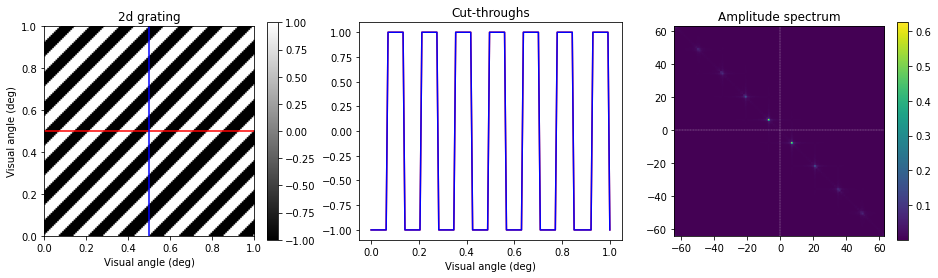

In [109]:
edge = grating(10., np.pi/4, 0, 1, 0)
edge[edge<=0] = -1
edge[edge>0] = 1
gratings_helper(edge)

## Modulating signals in frequency-space: Adding, subtracting, multiplying

### Adding

### Subtracting

### Multiplying / Filtering

## Some relevant filters

### "Ideal" filters: Lowpass, bandpass, highpass
Ideal because they remove perfectly the frequencies that should be removed.
However, point out ringing.
What do the different spatial frequency contents refer to? (keyword: edges)

### Gaussian filters: smoothing

### Difference-of-Gaussian (DoG) filters

### Oriented DoG filters

## Defining signals in frequency-space

### Example: Pink noise